In [1]:
import sys
sys.path.insert(0, '/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages')
sys.path.insert(0, '/home/mori/Documents/h2o/code/h2o-3/h2o-py/build')

# Custom loss function demo

In [2]:
import h2o
import pandas as pd
import datetime

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.utils.distributions import CustomDistributionGaussian

h2o.init(strict_version_check=False)

versionFromGradle='3.25.0',projectVersion='3.25.0.99999',branch='maurever_PUBDEV-4076_custom_loss_function',lastCommitHash='0c2369d7474e7fe4e9696056f6df410dd2b759fb',gitDescribe='jenkins-master-4684-24-g0c2369d747-dirty',compiledOn='2019-07-01 13:46:30',compiledBy='mori'
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 7 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.25.0.99999
H2O cluster version age:,2 days
H2O cluster name:,mori
H2O cluster total nodes:,1
H2O cluster free memory:,4.263 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [3]:
# load data 
data = pd.read_csv("../../smalldata/demos/item_demand_train.csv")
print(data.shape)

(913000, 4)


In [4]:
# Transform date column
def prepare_date(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column])
    index = pd.DatetimeIndex(data[date_column])
    data["year"] = index.year
    data["month"] = index.month
    data["day"] = index.day
    return data

# Create new features (lags, aggregated values based on lags)
def group_by_agg_lags(data):
    g = data.groupby(["store", "item"]).sales

    # lags older than 92 to be aple to prepare test data correctly 
    for i in range(92,366):
        data["lag_"+str(i)] = g.shift(i)
    data.dropna(inplace=True, axis=0)
    
    data["mean_last_year_week_7"] = data.iloc[:,266:274].mean(axis=1)
    data["mean_last_year_week_6"] = data.iloc[:,267:275].mean(axis=1)
    data["mean_last_year_week_5"] = data.iloc[:,268:276].mean(axis=1)
    data["mean_last_year_week_4"] = data.iloc[:,269:277].mean(axis=1)
    data["mean_last_year_week_3"] = data.iloc[:,270:278].mean(axis=1)
    data["mean_last_year_week_2"] = data.iloc[:,271:279].mean(axis=1)
    data["mean_last_year_week_1"] = data.iloc[:,272:280].mean(axis=1)
    data["moving_mean_last_year_week"] = data.iloc[:,280:287].mean(axis=1)
    data["sum_last_year_week"] = data.iloc[:,272:280].sum(axis=1)
    return data

In [5]:
# prepare date columns
data = prepare_date(data, "date")

# aggregate data, prepare lags, remove null rows
data = group_by_agg_lags(data)
print("New data shape:")
print(data.shape)

# split to train and test
train = data[data.date <= "2017-09-30"]
print("Training data shape:")
print(train.shape)

# last 3 month for testing
test = data[data.date > "2017-09-30"]
print("Testing data shape:")
print(test.shape)

New data shape:
(730500, 290)
Training data shape:
(684500, 290)
Testing data shape:
(46000, 290)


In [6]:
# Upload prepared data to h2o 
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# evaluate number of good predictions
def evaluate(test, predictions):
    predictions["actual"] = test.sales.values
    predictions.columns = ["prediction", "actual"]
    predictions["residual"] = predictions.actual - predictions.prediction
    predictions["fit"] = 0
    predictions.loc[predictions.residual < 0, "fit"] = 0
    predictions.loc[predictions.residual >= 0, "fit"] = 1
    items = predictions.shape[0]
    more_or_perfect = sum(predictions.fit)
    less = items - more_or_perfect
    return (items, less, more_or_perfect)

# print result of evaluation
def print_evaluation(predictions, less, more_or_perfect):
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline

    name = ["less", "more or perfect"]
    count = [less, more_or_perfect]
    rank = [-4, 4]

    #create scatter plot
    fig, ax = plt.subplots()
    ax.axis([-10,10,-14000,90000])
    ax.scatter(rank,count,s=count,marker='o', c=["red","green"])

    #label each bubble
    for n,c,r in zip(name, count, rank):
        plt.annotate("{}".format(c),xy=(r, c), ha="center", va="center", color="white", weight='bold', size=15)
        plt.annotate(n ,xy=(r, c), xytext=(0,15),
                 textcoords="offset points", ha="center", va="bottom", color="white", weight='bold', size=13)
    plt.title("Ratio between acceptable and nonacceptable predictions", weight='bold', size=15)
    plt.axis('off')
    plt.show()

    n, bins, patches = plt.hist(x=predictions.residual, bins='auto', color='#0504aa')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value of residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of residuals', weight='bold', size=15)
    maxfreq = n.max()
    plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


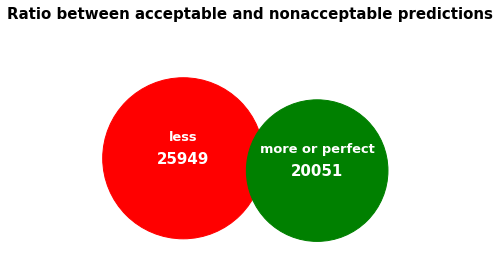

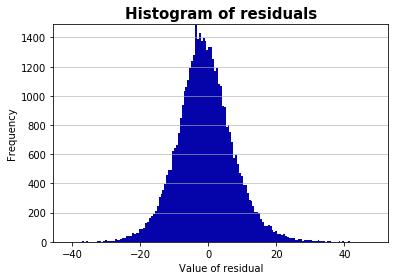

In [8]:
# Train GBM model with gaussian 
gbm_gaussian = H2OGradientBoostingEstimator(model_id="sales_model",
                                     ntrees=50,
                                     max_depth=5,
                                     score_each_iteration=True,
                                     distribution="gaussian")
gbm_gaussian.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

predictions = gbm_gaussian.predict(test_data=test_h2o).as_data_frame()

items, less, more_or_perfect = evaluate(test, predictions)

print_evaluation(predictions, less, more_or_perfect)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


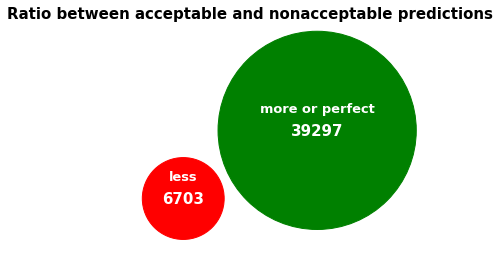

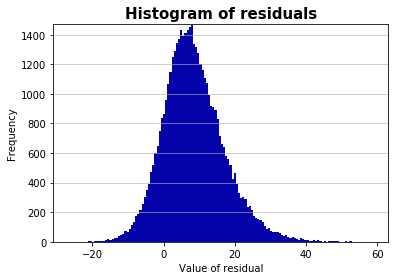

In [9]:
# Define asymmetric loss distribution from Gaussian distribution 
class AsymmetricLossDistribution(CustomDistributionGaussian):

    def gradient(self, y, f):
        error = y - f
        # bigger sales value is better error than the smaller one
        return 10 * error if error < 0 else 0.5 * error
    

name = "asymetric"
distribution_ref = h2o.upload_custom_distribution(AsymmetricLossDistribution, func_name="custom_"+name,
                                          func_file="custom_"+name+".py")

gbm_custom = H2OGradientBoostingEstimator(model_id="custom_sales_model",
                                     ntrees=50,
                                     max_depth=5,
                                     score_each_iteration=True,
                                     distribution="custom",
                                     custom_distribution_func=distribution_ref)
gbm_custom.train(y="sales", x=train_h2o.names, training_frame=train_h2o)

predictions = gbm_custom.predict(test_data=test_h2o).as_data_frame()
items, less, more_or_perfect = evaluate(test, predictions)
print_evaluation(predictions, less, more_or_perfect)